<a href="https://colab.research.google.com/github/peteray-dev/ML_CV_GS/blob/master/ML_CrossValidation_GridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cross Validation, Grid Search, Classification

* Machine Learning Concepts (MLC)


## Preamble: Importing and Configuring Essential Packages


In [60]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) },
    style='ticks',
    color_codes=True,
    font_scale=0.8
)
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sys
if 'google.colab' in sys.modules:
    !pip install -q dtreeviz
import dtreeviz

## Use Case: Titanic Dataset

In [61]:
# documentation can be found here: https://www.kaggle.com/competitions/titanic/data
titanic = pd.read_csv('https://raw.githubusercontent.com/gerberl/6G7V0015-2324/main/datasets/titanic.csv')

In [62]:
titanic.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [63]:
titanic['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

## Pre-Processing

In [64]:
# I'll make it possible for us to use `Sex` in our machine learning but
# mapping into a numeric feature using a simple strategy
tic = titanic.copy(deep=True)
tic['Sex'] = tic['Sex'].map({ 'male': 0, 'female': 1, np.NaN: 0} )
# Why not aggregate the number of people one travelled with?
tic['Companions'] = tic['SibSp'] + tic['Parch']
# remove categorical features (with string values) and other non-informative
# features
tic = tic[ ['Survived', 'Age', 'Sex', 'Pclass', 'Fare', 'Companions']]
# fill in missing values with the simplest strategy so as not to break the ML
tic = tic.fillna(tic.mean())

In [65]:
X, y = tic.drop(columns='Survived'), tic['Survived']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## A First Decision Tree for Illustration

0.7847891851011533 0.77068345323741


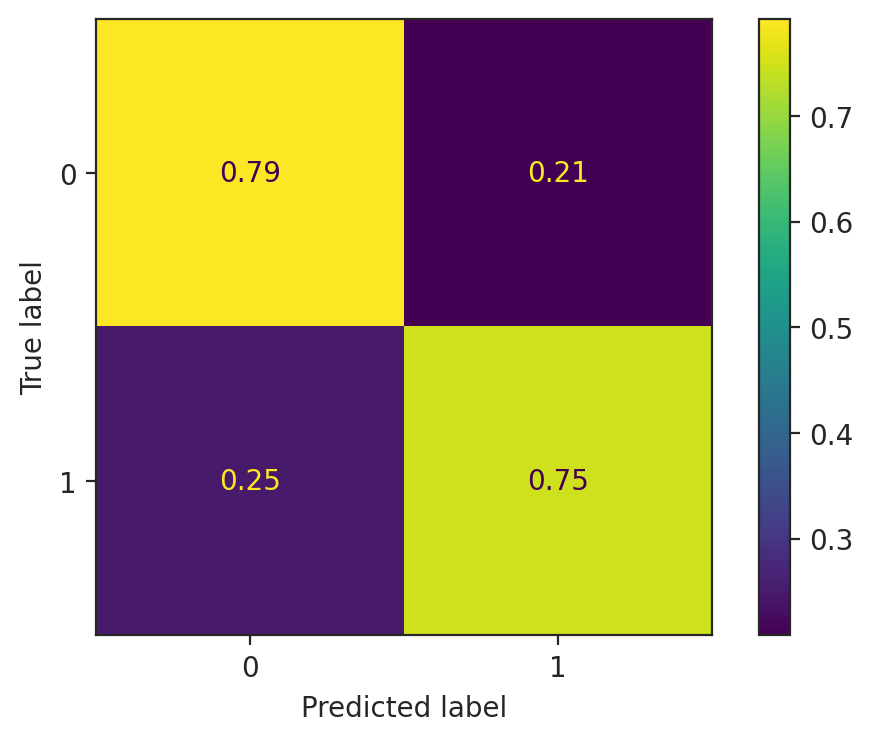

In [67]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)
print(
    balanced_accuracy_score(y_train, dt.predict(X_train)),
    balanced_accuracy_score(y_test, dt.predict(X_test))
)
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, dt.predict(X_test), normalize='true')
).plot();

|--- Sex <= 0.50
|   |--- Age <= 14.00
|   |   |--- class: 1
|   |--- Age >  14.00
|   |   |--- class: 0
|--- Sex >  0.50
|   |--- Pclass <= 2.50
|   |   |--- class: 1
|   |--- Pclass >  2.50
|   |   |--- class: 1



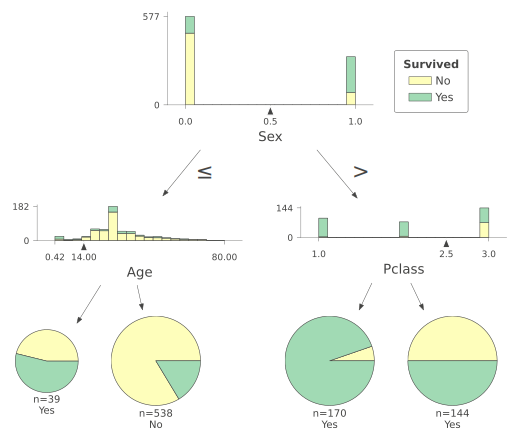

In [68]:
print(
    export_text(dt, feature_names=X.columns.to_list())
)
dtviz = dtreeviz.model(
    dt, X, y, target_name='Survived', feature_names=X.columns,
    class_names=["No", "Yes"]
)
dtviz.view(scale=1.5, fontname='sans-serif')

### More Experiments

* Experiment with trees with different configurations, using hyper-parameters such as `max_depth`, `min_samples_split`, and `min_samples_leaf`. Make use of grid search for hyper-parameter search.

* For each, do a quick analysis of accuracy on train and test. If promising, you might want to go deeper and visualise the tree with `export_text` or `dtreeviz`, and use a confusion matrix for a better understanding of the model's performance.

* Make use of cross validation for the measurement of the accuracy of models on the training data.

* Use this week's lecture as inspiration for looking into the ranking of results and, together with the graphical representation of the tree, make a justified decision for one or more of the tree models built.

In [69]:
param_grid={
    'max_depth' : [1,2,5,8,10],
    'min_samples_leaf' : [10, 20, 30]
}

In [70]:
from sklearn.model_selection import ParameterGrid
list(ParameterGrid(param_grid))

[{'max_depth': 1, 'min_samples_leaf': 10},
 {'max_depth': 1, 'min_samples_leaf': 20},
 {'max_depth': 1, 'min_samples_leaf': 30},
 {'max_depth': 2, 'min_samples_leaf': 10},
 {'max_depth': 2, 'min_samples_leaf': 20},
 {'max_depth': 2, 'min_samples_leaf': 30},
 {'max_depth': 5, 'min_samples_leaf': 10},
 {'max_depth': 5, 'min_samples_leaf': 20},
 {'max_depth': 5, 'min_samples_leaf': 30},
 {'max_depth': 8, 'min_samples_leaf': 10},
 {'max_depth': 8, 'min_samples_leaf': 20},
 {'max_depth': 8, 'min_samples_leaf': 30},
 {'max_depth': 10, 'min_samples_leaf': 10},
 {'max_depth': 10, 'min_samples_leaf': 20},
 {'max_depth': 10, 'min_samples_leaf': 30}]

In [71]:
from sklearn.model_selection import GridSearchCV

In [72]:
clf = GridSearchCV(dt, param_grid, return_train_score=True)
clf

GridSearchCV(estimator=DecisionTreeClassifier(max_depth=2),
             param_grid={'max_depth': [1, 2, 5, 8, 10],
                         'min_samples_leaf': [10, 20, 30]},
             return_train_score=True)

In [73]:
tic_result = clf.fit(X_train, y_train)

In [74]:
tic_df = pd.DataFrame(tic_result.cv_results_)
tic_df.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003204,0.000825,0.002116,0.000417,1,10,"{'max_depth': 1, 'min_samples_leaf': 10}",0.776119,0.798507,0.776119,...,0.788946,0.014158,5,0.792135,0.786517,0.792135,0.790654,0.783178,0.788924,0.003534
1,0.002107,0.000033,0.001609,0.000019,1,20,"{'max_depth': 1, 'min_samples_leaf': 20}",0.776119,0.798507,0.776119,...,0.788946,0.014158,5,0.792135,0.786517,0.792135,0.790654,0.783178,0.788924,0.003534
2,0.002124,0.000009,0.001601,0.000020,1,30,"{'max_depth': 1, 'min_samples_leaf': 30}",0.776119,0.798507,0.776119,...,0.788946,0.014158,5,0.792135,0.786517,0.792135,0.790654,0.783178,0.788924,0.003534
3,0.002613,0.000784,0.001959,0.000665,2,10,"{'max_depth': 2, 'min_samples_leaf': 10}",0.783582,0.791045,0.761194,...,0.769420,0.015126,15,0.799625,0.797753,0.816479,0.798131,0.796262,0.801650,0.007492
4,0.002263,0.000040,0.001618,0.000030,2,20,"{'max_depth': 2, 'min_samples_leaf': 20}",0.791045,0.791045,0.761194,...,0.770912,0.016733,13,0.795880,0.797753,0.816479,0.798131,0.796262,0.800901,0.007836


In [75]:
tic_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [76]:
list(tic_df)

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_max_depth',
 'param_min_samples_leaf',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score',
 'split0_train_score',
 'split1_train_score',
 'split2_train_score',
 'split3_train_score',
 'split4_train_score',
 'mean_train_score',
 'std_train_score']

In [77]:
tic_df[['param_max_depth',
 'param_min_samples_leaf', 'mean_train_score',
 'std_train_score', 'mean_test_score',
 'std_test_score',
 'rank_test_score','mean_score_time',
 'std_score_time',]].sort_values('rank_test_score')

,param_max_depth,param_min_samples_leaf,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score,mean_score_time,std_score_time
8,5,30,0.809879,0.003318,0.797890,0.008491,1,0.001663,0.000037
11,8,30,0.809879,0.003318,0.797890,0.008491,1,0.001925,0.000331
14,10,30,0.809879,0.003318,0.797890,0.008491,1,0.002813,0.000466
9,8,10,0.848798,0.008562,0.789047,0.067674,4,0.001638,0.000020
0,1,10,0.788924,0.003534,0.788946,0.014158,5,0.002116,0.000417
1,1,20,0.788924,0.003534,0.788946,0.014158,5,0.001609,0.000019
2,1,30,0.788924,0.003534,0.788946,0.014158,5,0.001601,0.000020
6,5,10,0.840937,0.007695,0.786040,0.050615,8,0.001865,0.000340
12,10,10,0.849547,0.008403,0.784570,0.061063,9,0.001724,0.000072
7,5,20,0.819985,0.002152,0.782954,0.034882,10,0.001710,0.000056


In [78]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
dt = dt.fit(X_train, y_train)

|--- Sex <= 0.50
|   |--- Age <= 14.00
|   |   |--- class: 1
|   |--- Age >  14.00
|   |   |--- Pclass <= 1.50
|   |   |   |--- Fare <= 30.60
|   |   |   |   |--- class: 0
|   |   |   |--- Fare >  30.60
|   |   |   |   |--- class: 0
|   |   |--- Pclass >  1.50
|   |   |   |--- Age <= 32.50
|   |   |   |   |--- Age <= 25.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Age >  25.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Age >  32.50
|   |   |   |   |--- Age <= 38.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Age >  38.50
|   |   |   |   |   |--- class: 0
|--- Sex >  0.50
|   |--- Pclass <= 2.50
|   |   |--- Fare <= 28.86
|   |   |   |--- class: 1
|   |   |--- Fare >  28.86
|   |   |   |--- Fare <= 84.83
|   |   |   |   |--- class: 1
|   |   |   |--- Fare >  84.83
|   |   |   |   |--- class: 1
|   |--- Pclass >  2.50
|   |   |--- Fare <= 19.74
|   |   |   |--- Fare <= 7.89
|   |   |   |   |--- class: 1
|   |   |   |--- Fare >  7.89
|   |   |   |   |--- cl

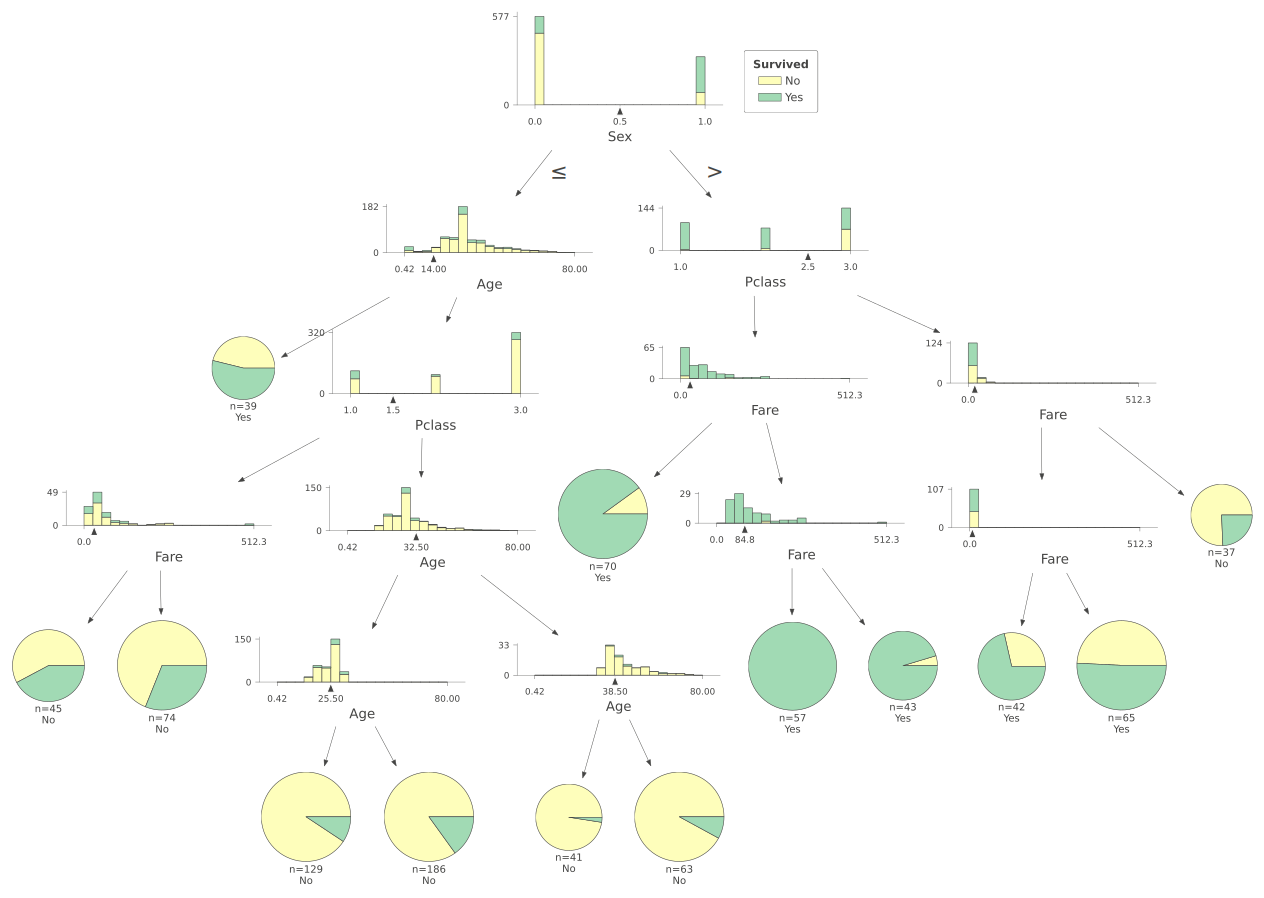

In [79]:
print(
    export_text(dt, feature_names=X.columns.to_list())
)
dtviz = dtreeviz.model(
    dt, X, y, target_name='Survived', feature_names=X.columns,
    class_names=["No", "Yes"]
)
dtviz.view(scale=1.5, fontname='sans-serif')

0.796114577424844 0.7863138060979789


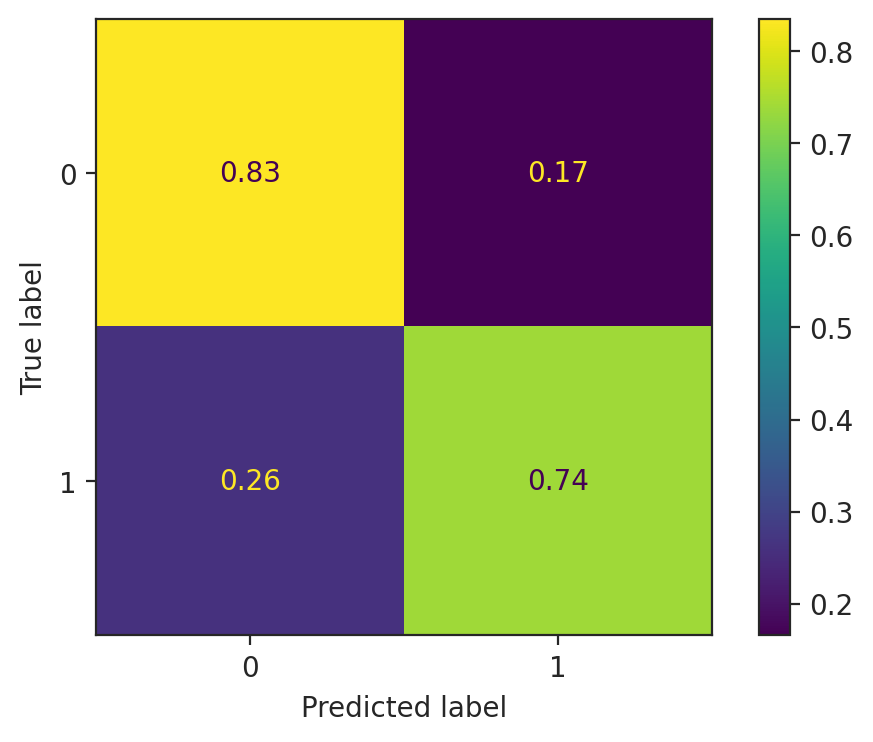

In [80]:
# For confusion marix
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
dt = dt.fit(X_train, y_train)
print(
    balanced_accuracy_score(y_train, dt.predict(X_train)),
    balanced_accuracy_score(y_test, dt.predict(X_test))
)

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, dt.predict(X_test), normalize='true')).plot()

In [81]:
dt_8 = DecisionTreeClassifier(max_depth=8, min_samples_leaf=30)
dt_8 = dt.fit(X_train, y_train)

|--- Sex <= 0.50
|   |--- Age <= 14.00
|   |   |--- class: 1
|   |--- Age >  14.00
|   |   |--- Pclass <= 1.50
|   |   |   |--- Fare <= 30.60
|   |   |   |   |--- class: 0
|   |   |   |--- Fare >  30.60
|   |   |   |   |--- class: 0
|   |   |--- Pclass >  1.50
|   |   |   |--- Age <= 32.50
|   |   |   |   |--- Age <= 25.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Age >  25.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Age >  32.50
|   |   |   |   |--- Age <= 38.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Age >  38.50
|   |   |   |   |   |--- class: 0
|--- Sex >  0.50
|   |--- Pclass <= 2.50
|   |   |--- Fare <= 28.86
|   |   |   |--- class: 1
|   |   |--- Fare >  28.86
|   |   |   |--- Fare <= 84.83
|   |   |   |   |--- class: 1
|   |   |   |--- Fare >  84.83
|   |   |   |   |--- class: 1
|   |--- Pclass >  2.50
|   |   |--- Fare <= 19.74
|   |   |   |--- Fare <= 7.89
|   |   |   |   |--- class: 1
|   |   |   |--- Fare >  7.89
|   |   |   |   |--- cl

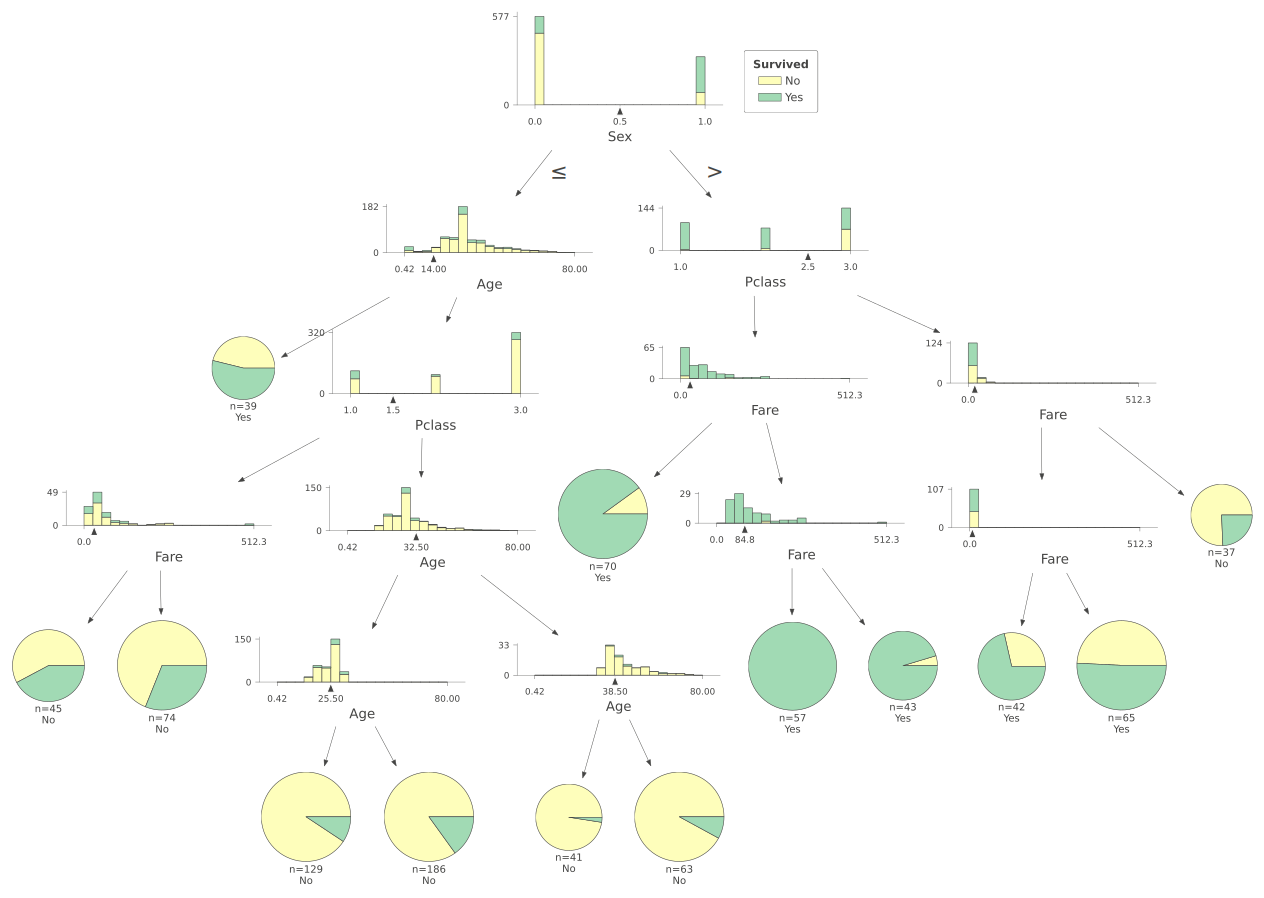

In [82]:
print(
    export_text(dt_8, feature_names=X.columns.to_list())
)
dtviz = dtreeviz.model(
    dt_8, X, y, target_name='Survived', feature_names=X.columns,
    class_names=["No", "Yes"]
)
dtviz.view(scale=1.5, fontname='sans-serif')

In [83]:
dt_8 = DecisionTreeClassifier(max_depth=8, min_samples_leaf=30)
dt_8.fit(X_train, y_train)
print(
    balanced_accuracy_score(y_train, dt_8.predict(X_train)),
    balanced_accuracy_score(y_test, dt_8.predict(X_test))
)


0.796114577424844 0.7863138060979789


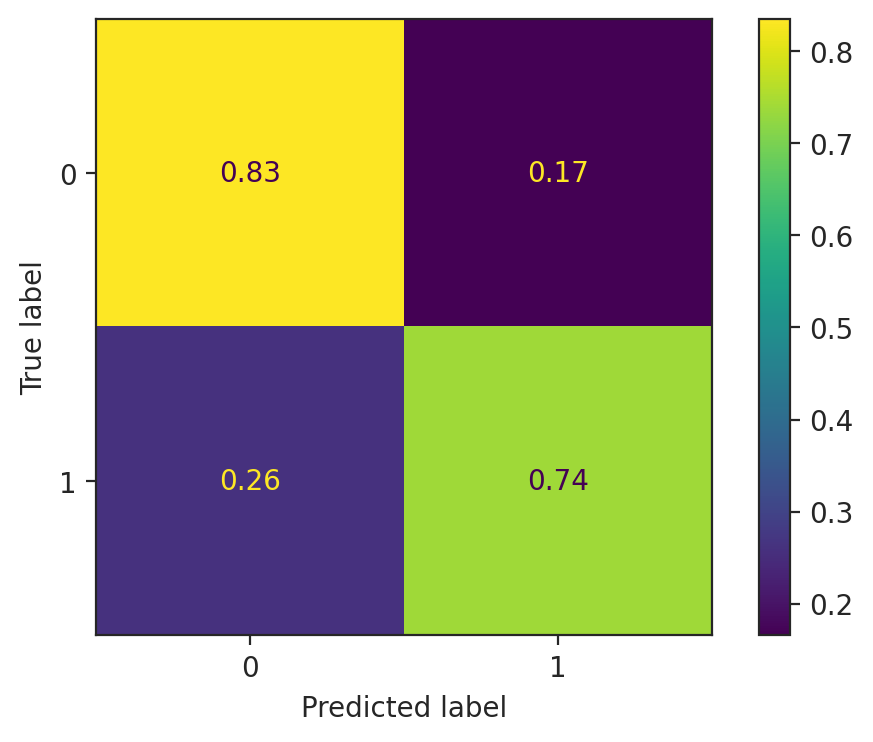

In [84]:
ConfusionMatrixDisplay(confusion_matrix(y_test, dt_8.predict(X_test), normalize='true')).plot()

In [85]:

###CROSS VALIDATION
dt_8 = DecisionTreeClassifier(max_depth=8, min_samples_leaf=30)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_8, X, y, cv=10)
scores

array([0.74444444, 0.7752809 , 0.73033708, 0.78651685, 0.80898876,
       0.80898876, 0.84269663, 0.7752809 , 0.85393258, 0.7752809 ])

In [86]:
scores.mean()

0.7901747815230962